# Confidence estimates: the bootstrap and the jackknife

Often, expressions for computing confidence limits for estimated parameters are based on strong assumptions, such as the data being truly Gaussian and having large samples. Two alternative methods exist that are powerful and easy to compute, which rely on resampling the data set $\{x_i\}$.

### Bootstrap

Our data set $\{x_i\}$ is drawn from a distribution function $h(x)$. If we knew $h(x)$ and its descriptive parameters, we could compute any statistic without uncertainty. However, we do not know $h(x)$, and the best we can do are computations that rely on various estimates of $h(x)$ derived from the data, which we call here $f(x)$. Bootstrapping is based on the approximation

$$f(x) = \frac{1}{N}\sum^N_{i=1}\delta (x-x_i) $$

where $\delta(x)$ is the Dirac delta function. The function $f(x)$ *maximizes* the probability of obtaining observed data values. We can now pretend that $f(x)$ is actually $h(x)$, and use it to perform various computations. For example, we could use the equation above to estimate the mean and its uncertainty.

When finding parameter uncertainties, we can use this equation to draw new data sets. There are $N!$ ways to get sample that matches the original and $N^N$ possible datasets – thus, the probability that the new dataset matches the original is $N!/N^N$.

Essentially, we draw from the observed data set with replacement: select $N$ new index values $j$ from the range $i = 1, . . . , N$, and this becomes the new sample. This resampling is done $B$ times, and the resulting $B$ data sets are used to compute the statistic of interest $B$ times. The distribution of these values maps the uncertainty of the statistics of interest and can be used to estimate its bias and standard error, as well as other statistics. This approach described above is known as the **nonparametric bootstrap method**; there is also the parametric bootstrap method which draws samples from the best-fit model.


The example below demonstrates the nonparametric bootstrap method for estimating uncertainty in the standard deviation and $\sigma_G$ (Eq. $2$). To do this, we will use `astroML.resample.bootstrap` and we'll also need to import `sigmaG` from `astroML.stats`. Our data sample will have $m = 1000$ values drawn from a Gaussian distribution with $\mu$ = 0 and $\sigma$ = 1. Then we will compute our bootstrap resamplings where we'll resample 10000 times. Afterward, we will compute the theoretical expectations for the two distributions using Eqs. $1$ and $2$. Note that $s$ is the *sample standard deviation* and that these equations only hold for Gaussian distributions.

$$\qquad\qquad\qquad\sigma_s = \frac{s}{\sqrt{2(N-1)}}\qquad\qquad \qquad (1)$$


$$\qquad\qquad\qquad\qquad\sigma_{\sigma_G} = \frac{1.06s}{\sqrt{N}}\qquad\qquad\quad\quad(2)$$

In [1]:
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt
from astroML.resample import bootstrap
from astroML.stats import sigmaG

m = 1000  # number of points
n = 10000  # number of bootstraps

# sample values from a normal distribution
np.random.seed(123)
data = norm(0, 1).rvs(m)

# Compute bootstrap resamplings of data
mu1_bootstrap = bootstrap(data, n,  np.std, kwargs=dict(axis=1, ddof=1))
mu2_bootstrap = bootstrap(data, n, sigmaG, kwargs=dict(axis=1))

# # Compute the theoretical expectations for the two distributions
x = np.linspace(0.8, 1.2, 1000)

sigma1 = 1. / np.sqrt(2 * (m - 1))
pdf1 = norm(1, sigma1).pdf(x)

sigma2 = 1.06 / np.sqrt(m) 
pdf2 = norm(1, sigma2).pdf(x)

Next, we will plot the histograms, which show the distribution of the resulting $s$ and $\sigma_G$, along with the theoretical distributions.

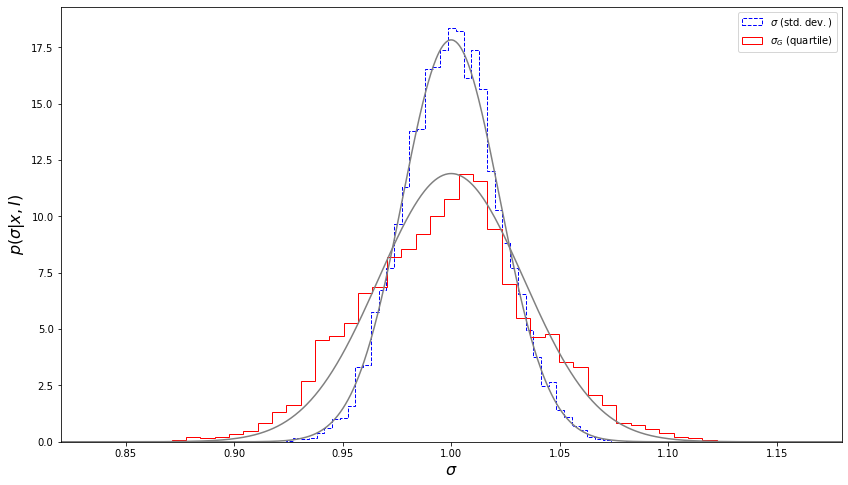

In [2]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.hist(mu1_bootstrap, bins=50, density=True, histtype='step',
        color='blue', ls='dashed', label=r'$\sigma\ {\rm (std. dev.)}$')
ax.plot(x, pdf1, color='gray')

ax.hist(mu2_bootstrap, bins=50, density=True, histtype='step',
        color='red', label=r'$\sigma_G\ {\rm (quartile)}$')
ax.plot(x, pdf2, color='gray')

ax.set_xlim(0.82, 1.18)

ax.set_xlabel(r'$\sigma$', fontsize = 16)
ax.set_ylabel(r'$p(\sigma|x,I)$', fontsize = 16)

ax.legend()

plt.show()

We can see that the bootstrap estimates of uncertainties are in good agreement with the values computed using Eqs. $1$ and $2$.

### Jackknife

The jackknife approach is similar to the bootstrap method, but rather than drawing a data set identical in size to the original data set during the resampling step, one or more observations are left unused when computing the statistic of interest. 

We can call this statistic $\alpha$ with its value computed from the full data set $\alpha_N$. Assuming that one observation (data point) is removed when resampling, we can form $N$ such data sets and compute a statistic of interest, $\alpha_i^*$, for each of them. It can be shown that in the case of a single observation removed from the data set, a bias-corrected jackknife estimate of $\alpha$ can be computed as

$$\:\qquad\qquad\qquad\qquad\alpha^J = \alpha_N + \Delta \alpha\qquad\qquad\qquad\qquad\: (3)$$

where the jackknife correction is

$$ \quad\qquad\qquad\Delta \alpha = (N-1) \bigg( \alpha_N - \frac{1}{N} \sum^N_{i=1} \alpha_i^*\bigg).\qquad\qquad(4) $$

For estimators which are asymptotically normal, the standard error for a jackknife estimate $\alpha^J$ is

$$ \qquad\sigma_\alpha = \sqrt{\frac{1}{N(N-1)}\sum^N_{i=1} [N\alpha_N-\alpha^J-(N-1)\alpha_i^*]^2}.\qquad(5)$$

We will visualize this below, again drawing our sample from a Gaussian with 1000 data points. Then we'll use `astroML.resample.jackknife` and compute the jackknife resamplings of data using $\sigma$ and $\sigma_G$. Note that $\mu_s$ is the mean of the standard deviation-based width, and $\mu_{\sigma_G}$ is the mean of the interquartile-based width. Additionally, computing the jackknife resampling for $\sigma_G$ should **not** be done in practice; we will see the jackknife fails for rank-based statistics.

In [3]:
from astroML.resample import jackknife
from astroML.stats import sigmaG

np.random.seed(123)
m = 1000
data = norm(0, 1).rvs(m)

# Compute jackknife resampling

# Standard deviation based
mu_s, sigma_mu_s, mu_s_raw = jackknife(data, np.std,
                                    kwargs=dict(axis=1, ddof=1),
                                    return_raw_distribution=True)

pdf1_theory = norm(1, 1. / np.sqrt(2 * (m - 1)))
pdf1_jackknife = norm(mu_s, sigma_mu_s)

# Sigma_G based
mu_sigG, sigma_mu_sigG, mu_sigG_raw = jackknife(data, sigmaG,
                                    kwargs=dict(axis=1),
                                    return_raw_distribution=True)
pdf2_theory = norm(data.std(), 1.06 / np.sqrt(m))
pdf2_jackknife = norm(mu_sigG, sigma_mu_sigG)


print(f"mu_s = {mu_s:.3}, sigma_mu_s = {sigma_mu_s:.3}")
print(f"mu_sigmaG = {mu_sigG:.3}, sigma_mu_sigmaG = {sigma_mu_sigG:.3}")

mu_s = 1.0, sigma_mu_s = 0.0223
mu_sigmaG = 0.598, sigma_mu_sigmaG = 0.0314


Next, we'll plot the distributions. The left panel will show a histogram of the widths determined using the sample standard deviation and the interquartile range. The right panel will show the corrected jackknife estimates (Eqs. $3$ and $5$) for the two methods. The gray lines show the theoretical results given by eq. $1$ for $s$ and eq. $2$ for $\sigma_G$.

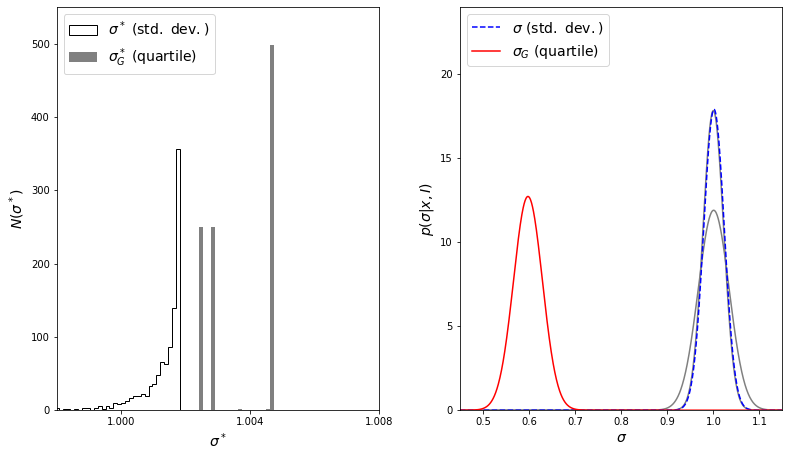

In [4]:
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0.11, right=0.95, bottom=0.2, top=0.9,
                    wspace=0.25)

ax = fig.add_subplot(121)
ax.hist(mu_s_raw, np.linspace(0.996, 1.008, 100),
        label=r'$\sigma^*\ {\rm (std.\ dev.)}$',
        histtype='stepfilled', fc='white', ec='black', density=False)
ax.hist(mu_sigG_raw, np.linspace(0.996, 1.008, 100),
        label=r'$\sigma_G^*\ {\rm (quartile)}$',
        histtype='stepfilled', fc='gray', density=False)
ax.legend(loc='upper left', handlelength=2, fontsize = 14)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.004))
ax.set_xlabel(r'$\sigma^*$', fontsize = 14)
ax.set_ylabel(r'$N(\sigma^*)$', fontsize = 14)
ax.set_xlim(0.998, 1.008)
ax.set_ylim(0, 550)

ax = fig.add_subplot(122)
x = np.linspace(0.45, 1.15, 1000)
ax.plot(x, pdf1_jackknife.pdf(x),
        color='blue', ls='dashed', label=r'$\sigma\ {\rm (std.\ dev.)}$',
        zorder=2)
ax.plot(x, pdf1_theory.pdf(x), color='gray', zorder=1)

ax.plot(x, pdf2_jackknife.pdf(x),
        color='red', label=r'$\sigma_G\ {\rm (quartile)}$', zorder=2)
ax.plot(x, pdf2_theory.pdf(x), color='gray', zorder=1)
plt.legend(loc='upper left', handlelength=2, fontsize = 14)

ax.set_xlabel(r'$\sigma$', fontsize = 14)
ax.set_ylabel(r'$p(\sigma|x,I)$', fontsize = 14)
ax.set_xlim(0.45, 1.15)
ax.set_ylim(0, 24)

plt.show()

The result for $\sigma$ matches the theoretical result almost exactly, but note the failure of the jackknife to estimate $\sigma_G$ correctly.

The confidence limits for $\alpha$ can be found using Student’s t distribution with $t = (\alpha - \alpha^J)/\sigma_\alpha$ and $N-1$ degrees of freedom. The jackknife standard error is more reliable than the jackknife bias correction because it is based on a simpler approximation. For the sample whose bootstrap uncertainty estimates for $s$ and $\sigma_G$ are shown in the figure above, the jackknife method (eq. $5$) gives similar widths as with the bootstrap method. However, note that the bias correction estimate for $\sigma_G$ given by eq. $4$ is completely unreliable. 

This failure is a general problem with the standard jackknife method, which performs well for smooth differential statistics such as the mean and standard deviation, but does not perform well for medians, quantiles, and other rank-based statistics. For these sorts of statistics, a jackknife implementation that removes more than one observation can overcome this problem. The reason for this failure becomes apparent upon examination of the figure above: for $\sigma_G$, the vast majority of jackknife samples yield one of three discrete values! Because quartiles are insensitive to the removal of outliers, all samples created by the removal of a point larger than $q_{75}$ lead to precisely the same estimate. The same is true for removal of any point smaller than $q_{25}$, and for any point in the range $q_{25} < x < q_{75}$. Because of this, the jackknife cannot accurately sample the error distribution, which leads to a gross misestimate of the result.

So, should we use bootstrap or jackknife in practice? Although based on different approximations, they typically produce similar results for smooth statistics, especially for large samples. 

* Jackknife estimates are usually easier to calculate and apply to complex sampling schemes. Additionally, they automatically remove bias. 

* Bootstrap is better for computing confidence intervals because it does not involve the assumption of asymptotic normality (i.e., it maps out the shape of the distribution). 

*Note that bootstrap gives slightly different results even if the data set is fixed (because random resampling is performed), while jackknife gives repeatable results for a given data set (because all possible permutations are used).*

Of course, when feasible, it's helpful to use both bootstrap and jackknife and critically compare their results. Both methods should be used with caution when $N$ is small.

### Useful SciPy functions

Both `Astropy` and `AstroML` contain some routines for performing basic nonparametric jackknife and bootstrap: `astroML.resample.jackknife` and `astroML.resample.bootstrap`.

In [5]:
import numpy as np
from astropy.stats import jackknife_stats
np.random.seed(0)
x = np.random.normal(loc=0, scale=1, size=1000)
estimate, bias, stderr, conf_interval = jackknife_stats(x, np.std)
print(estimate , stderr)

0.9877692831445253 0.021862029271295866
